# Rain in Australia - Logistic Regression

Homework: Weather prediction using logistic regression with proper temporal split

Dataset: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

## 1. Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

## 2. Load the dataset

In [2]:
df = pd.read_csv('weatherAUS.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (145460, 23)

First few rows:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
print("Dataset info:")
df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       

In [4]:
print("Missing values percentage:")
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0])

Missing values percentage:
Sunshine         48.009762
Evaporation      43.166506
Cloud3pm         40.807095
Cloud9am         38.421559
Pressure9am      10.356799
Pressure3pm      10.331363
WindDir9am        7.263853
WindGustDir       7.098859
WindGustSpeed     7.055548
Humidity3pm       3.098446
WindDir3pm        2.906641
Temp3pm           2.481094
RainTomorrow      2.245978
Rainfall          2.241853
RainToday         2.241853
WindSpeed3pm      2.105046
Humidity9am       1.824557
Temp9am           1.214767
WindSpeed9am      1.214767
MinTemp           1.020899
MaxTemp           0.866905
dtype: float64


## 3. Data preprocessing and temporal feature engineering

### 3.1. Remove features with high percentage of missing values

In [5]:
threshold = 40
missing_pct = df.isnull().sum() / len(df) * 100
cols_to_drop = missing_pct[missing_pct > threshold].index.tolist()

print(f"Columns to drop (>{threshold}% missing): {cols_to_drop}")

df = df.drop(columns=cols_to_drop)
print(f"\nDataset shape after dropping columns: {df.shape}")

Columns to drop (>40% missing): ['Evaporation', 'Sunshine', 'Cloud3pm']

Dataset shape after dropping columns: (145460, 20)


### 3.2. Create subsets for numerical and categorical features

In [6]:
target = 'RainTomorrow'

df = df.dropna(subset=[target])

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if target in numerical_cols:
    numerical_cols.remove(target)
if target in categorical_cols:
    categorical_cols.remove(target)

if 'Date' in categorical_cols:
    categorical_cols.remove('Date')

print(f"Numerical features: {numerical_cols}")
print(f"\nCategorical features: {categorical_cols}")

Numerical features: ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Temp9am', 'Temp3pm']

Categorical features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


### 3.3. Convert Date column to datetime and create Year and Month features

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

print("Created temporal features:")
print(df[['Date', 'Year', 'Month']].head())
print(f"\nYear range: {df['Year'].min()} - {df['Year'].max()}")

Created temporal features:
        Date  Year  Month
0 2008-12-01  2008     12
1 2008-12-02  2008     12
2 2008-12-03  2008     12
3 2008-12-04  2008     12
4 2008-12-05  2008     12

Year range: 2007 - 2017


### 3.4. Move Year to numerical features, Month stays categorical

In [8]:
numerical_cols.append('Year')
categorical_cols.append('Month')

print(f"Updated numerical features: {numerical_cols}")
print(f"\nUpdated categorical features: {categorical_cols}")

Updated numerical features: ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Temp9am', 'Temp3pm', 'Year']

Updated categorical features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Month']


### 3.5. Split data: last year for testing, all others for training

In [9]:
max_year = df['Year'].max()
print(f"Maximum year in dataset: {max_year}")
print(f"Using {max_year} for testing, all previous years for training")

train_mask = df['Year'] < max_year
test_mask = df['Year'] == max_year

X_train_num = df.loc[train_mask, numerical_cols]
X_test_num = df.loc[test_mask, numerical_cols]

X_train_cat = df.loc[train_mask, categorical_cols]
X_test_cat = df.loc[test_mask, categorical_cols]

y_train = df.loc[train_mask, target]
y_test = df.loc[test_mask, target]

print(f"\nTrain size: {len(X_train_num)}")
print(f"Test size: {len(X_test_num)}")
print(f"\nTarget distribution in train:")
print(y_train.value_counts(normalize=True))
print(f"\nTarget distribution in test:")
print(y_test.value_counts(normalize=True))

Maximum year in dataset: 2017
Using 2017 for testing, all previous years for training

Train size: 133727
Test size: 8466

Target distribution in train:
RainTomorrow
No     0.77481
Yes    0.22519
Name: proportion, dtype: float64

Target distribution in test:
RainTomorrow
No     0.791755
Yes    0.208245
Name: proportion, dtype: float64


## 4. Handle missing values using SimpleImputer

In [10]:
num_imputer = SimpleImputer(strategy='mean')
X_train_num_imputed = num_imputer.fit_transform(X_train_num)
X_test_num_imputed = num_imputer.transform(X_test_num)

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat_imputed = cat_imputer.fit_transform(X_train_cat)
X_test_cat_imputed = cat_imputer.transform(X_test_cat)

print("Missing values handled")
print(f"Numerical features shape: {X_train_num_imputed.shape}")
print(f"Categorical features shape: {X_train_cat_imputed.shape}")

Missing values handled
Numerical features shape: (133727, 14)
Categorical features shape: (133727, 6)


## 5. Normalize numerical features using StandardScaler

In [11]:
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num_imputed)
X_test_num_scaled = scaler.transform(X_test_num_imputed)

print("Numerical features normalized")
print(f"Mean of first feature in train: {X_train_num_scaled[:, 0].mean():.6f}")
print(f"Std of first feature in train: {X_train_num_scaled[:, 0].std():.6f}")

Numerical features normalized
Mean of first feature in train: -0.000000
Std of first feature in train: 1.000000


## 6. Encode categorical features using OneHotEncoder

In [12]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat_encoded = encoder.fit_transform(X_train_cat_imputed)
X_test_cat_encoded = encoder.transform(X_test_cat_imputed)

print("Categorical features encoded")
print(f"Encoded features shape: {X_train_cat_encoded.shape}")
print(f"Number of categories: {len(encoder.categories_)}")

Categorical features encoded
Encoded features shape: (133727, 111)
Number of categories: 6


## 7. Combine numerical and categorical features, train LogisticRegression model

In [13]:
X_train = np.hstack([X_train_num_scaled, X_train_cat_encoded])
X_test = np.hstack([X_test_num_scaled, X_test_cat_encoded])

print(f"Final training set shape: {X_train.shape}")
print(f"Final test set shape: {X_test.shape}")

Final training set shape: (133727, 125)
Final test set shape: (8466, 125)


In [14]:
clf = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
clf.fit(X_train, y_train)

print("Model trained successfully")

Model trained successfully


## 8. Calculate metrics and compare with baseline model

In [15]:
y_pred = clf.predict(X_test)

print("="*60)
print("MODEL EVALUATION")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

MODEL EVALUATION

Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.95      0.91      6703
         Yes       0.72      0.45      0.55      1763

    accuracy                           0.85      8466
   macro avg       0.79      0.70      0.73      8466
weighted avg       0.84      0.85      0.83      8466



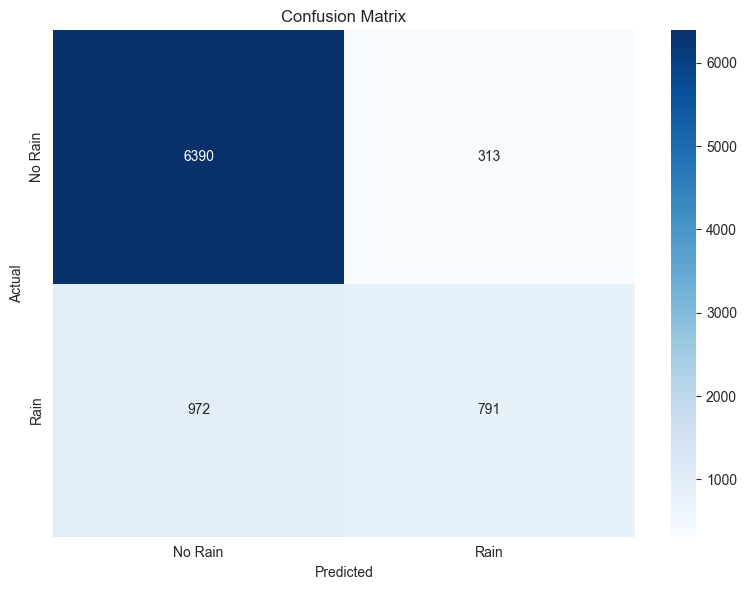

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Rain', 'Rain'],
            yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## 9. Experiment with different solvers

In [17]:
solvers = ['lbfgs', 'liblinear', 'saga']
results = []

for solver in solvers:
    print(f"\nTesting solver: {solver}")
    model = LogisticRegression(max_iter=1000, random_state=42, solver=solver)
    model.fit(X_train, y_train)
    y_pred_solver = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_solver)
    results.append({'solver': solver, 'accuracy': accuracy})
    print(f"Accuracy: {accuracy:.4f}")

results_df = pd.DataFrame(results)
print("\n" + "="*40)
print("SOLVER COMPARISON")
print("="*40)
print(results_df)


Testing solver: lbfgs
Accuracy: 0.8482

Testing solver: liblinear
Accuracy: 0.8481

Testing solver: saga
Accuracy: 0.8481

SOLVER COMPARISON
      solver  accuracy
0      lbfgs  0.848216
1  liblinear  0.848098
2       saga  0.848098


## 10. Conclusions
The model achieved 85% accuracy, better than the expected 80%. However, it's much better at predicting "no rain" (95% recall) than actual rain (only 45% recall). This means it missed nearly half of the rainy days - 970 out of 1,763.
This conservative behavior makes sense since 79% of days had no rain. The model learned to predict "no rain" more often, which gives high overall accuracy but makes it unreliable for catching actual rainy days.
The temporal split using 2017 for testing prevented data leakage. All three solvers tested (lbfgs, liblinear, saga) performed nearly identically (~84.8%), confirming the model converged properly.
Main takeaway: 85% accuracy looks good, but the low recall for rain (45%) is a significant weakness for practical weather forecasting.